# Исследование методов классификации изображений рукописных цифр с помощью полносвязной нейронной сети

Дисциплина: "**Системы поддержки принятия решений**"

**Подготовил**: Лосев А. П., гр. ИСТ-131м, **вариант 6**.

Метод оптимизации — **SGD**, число нейронов в скрытом слое — **20**, шаг градиентного спуска — **0,01**.

**Принял**: к.т.н., доцент кафедры ИУС, Литвинов В. Л.

Импорт необходимых зависимостей и инициализация *random seed*:

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

Подключение датасета MNIST, содержащего в себе примеры рукописных цифр, для обучения и верификации:

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

Загрузка необходимых данных и их разметки:

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Users\Arseniy Losev\.conda\envs\SPPR_working\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Получение информации о типе данных для переменных обучения и верификации:

In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

Изменение типа данных на число с плавающей точкой для корректной работы:

In [5]:
X_train = X_train.float()
X_test = X_test.float()

Получение информации о размерности массивов для обучения:

In [6]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

Получение информации о размерности массивов для верификации:

In [7]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

Визуализация одного из изображений рукописной цифры, используемого в наборе для обучения:

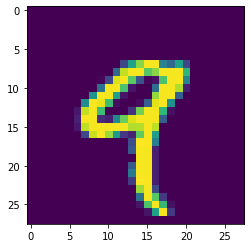

tensor(9)


In [8]:
import matplotlib.pyplot as plt
plt.imshow(X_train[4, :, :])
plt.show()
print(y_train[4])

Преобразование картинки из тензора в вектор:

In [9]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

Создание модели сети для классификации цифр:

In [10]:
class MNISTNet(torch.nn.Module): 
    def __init__(self, n_hidden_neurons): 
        super(MNISTNet, self).__init__() 
        self.fc1 = torch.nn.Linear(28 * 28, 20) 
        self.ac1 = torch.nn.Sigmoid()
        # self.fc2 = torch.nn.Linear(20, 20)
        # self.ac2 = torch.nn.Sigmoid()
        self.fc3 = torch.nn.Linear(20, 10) 
    def forward(self, x): 
        x = self.fc1(x) 
        x = self.ac1(x) 
        # x = self.fc2(x)
        # x = self.ac2(x) 
        x = self.fc3(x)
        return x 
mnist_net = MNISTNet(100)

Проверка доступности графического процессора для выполнения вычислений на нём:

In [11]:
torch.cuda.is_available()

True

Проверка наличия исполняемых на видеокарте операций/процессов:

In [12]:
!nvidia-smi

Sat May 21 16:28:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P0    N/A /  N/A |      0MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Выбор GPU как первичного вычислительного устройства и релокация модели на графический процессор:

In [13]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

Определение функции потерь и функции оптимизации:

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(mnist_net.parameters(), lr=0.01)

Задание размера бэтча и запуск процесса обучения (следует прекратить обучение с помощью *KeyboardInterrupt* в момент, когда точность предсказаний дойдёт до значения ≈0.95):

In [15]:
%%time
batch_size = 100
test_accuracy_history = []
test_loss_history = []
train_loss_history = []

# X_test = X_test.to(device)
# y_test = y_test.to(device)
# X_train = X_train.to(device)
# y_train = y_train.to(device)

for epoch in range(100):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes] #.to(device)
        y_batch = y_train[batch_indexes] #.to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    loss_for_history = loss(test_preds, y_test).detach()
    test_loss_history.append(loss_for_history)
    
    train_preds = mnist_net.forward(X_train)
    loss_for_history_2 = loss(train_preds, y_train).detach()
    train_loss_history.append(loss_for_history_2)
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.8272)
tensor(0.8678)
tensor(0.8685)
tensor(0.8839)
tensor(0.8865)
tensor(0.8864)
tensor(0.8874)
tensor(0.8995)
tensor(0.8982)
tensor(0.8957)
tensor(0.9015)
tensor(0.8996)
tensor(0.9031)
tensor(0.9061)
tensor(0.9066)
tensor(0.9034)
tensor(0.9062)
tensor(0.9012)
tensor(0.9060)
tensor(0.9034)
tensor(0.9043)
tensor(0.9096)
tensor(0.9063)
tensor(0.9070)
tensor(0.9075)
tensor(0.9055)
tensor(0.9090)
tensor(0.9069)
tensor(0.9124)
tensor(0.9072)
tensor(0.9135)
tensor(0.9048)
tensor(0.9070)
tensor(0.9131)
tensor(0.9178)
tensor(0.9154)
tensor(0.9123)
tensor(0.9126)
tensor(0.9111)
tensor(0.9097)
tensor(0.9139)
tensor(0.9141)
tensor(0.9129)
tensor(0.9128)
tensor(0.9114)
tensor(0.9109)
tensor(0.9097)
tensor(0.9192)
tensor(0.9194)
tensor(0.9190)
tensor(0.9159)
tensor(0.9182)
tensor(0.9180)
tensor(0.9171)
tensor(0.9161)
tensor(0.9193)
tensor(0.9188)
tensor(0.9166)
tensor(0.9160)
tensor(0.9178)
tensor(0.9238)
tensor(0.9175)
tensor(0.9143)
tensor(0.9225)
tensor(0.9174)
tensor(0.9228)
tensor(0.9

График точности предсказаний на эпохах обучения:

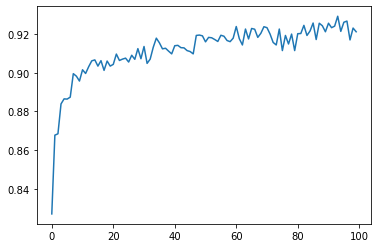

In [16]:
plt.plot(test_accuracy_history)

График функции потерь на эпохах обучения:

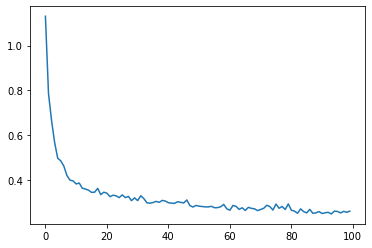

In [17]:
plt.plot(test_loss_history)

***
**Задание на лабораторную работу**
***

1. Исследовать нейронную сеть при заданных начальных параметрах (Метод оптимизации — **SGD**, число нейронов в скрытом слое — **20**, шаг градиентного спуска — **0,01**);
2. Исследовать зависимость точности распознавания от количества нейронов в скрытом слое, количества слоев, метода активации;
3.	Замерьте время вычисления 100 эпох на CPU и на GPU. Какое ускорение вы наблюдаете?
4.	Постройте на одном графике loss для train и test. Имеется ли переобучение сети?

***
**Ответы на задание**
***

1. При заданных начальных параметрах нейронная сеть обучается до значения точности предсказания **≈0.92**, обучение нейросети на центральном процессоре осуществляется за **1 минуту и 23 секунды**, а на графическом процессоре за **1 минуту и 52 секунды**. Данные показатели справедливы для периода оюучения в **100 эпох**.
2. При увеличении количества нейронов в два раза точность предсказания увеличилась до **≈0.95**, а при уменьшении в два раза уменьшилась до **≈0.89**. Время обучения изменялось в незначительных диапазонах **до 5 секунд**. Добавление скрытого слоя к текущей конфигурации нейросети не изменило ни точность предсказания, ни время обучения. Изменение метода активации с **SGD** на **ADAM** привело к увеличению времени обучения (от **1 минуты и 23 секунд** до **2 минут и 11 секунд**) и дало уменьшение точности предсказания с **≈0.92** до **≈0.89**.
3. Время обучения нейронной сети указано в ответе на пункт 1.
4. Графическая зависимость функций потерь датасетов *Train* и *Test* приведена на рисунке. Графики очень схожи, значит, переобучение отсутствует.

График функции потерь для датасетов *Train* и *Test*:

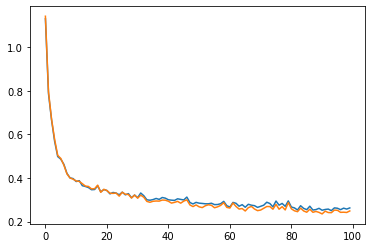

In [18]:
plt.plot(test_loss_history)
plt.plot(train_loss_history)

**Выводы**: при выполнении лабораторной работы были получены практические навыки разработки искусственной нейронной сети для классификации рукописных цифр из общедоступного датасета *MNIST*. Итогом работы стала система классификации изображений, которая может исполняться как на CPU, так и на GPU. В случае с персональным компьютером, который использовался для выполнения лабораторной работы, существенного выигрыша при использовании GPU не получается по причине устаревшего поколения графического процессора и низких вычислительных мощностей (**Nvidia MX150**) по сравнению с центральным процессором(**Intel Core I5-8250U**). Однако обучение и реализация исполняются и на CPU, и на GPU без технических сложностей, значит, работа выполнена успешно.